# TimesNet Tutorial for Anomaly Detection
This notebook demonstrates how to use TimesNet for time series anomaly detection

## 1. Packages import and prepare arguments

In [ ]:
import os
import time

import numpy as np
import torch.cuda
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from tsadlib.metrics.adjustment import point_adjustment

from tsadlib import ConfigType
from tsadlib import OneEarlyStopping
from tsadlib import TimesNet
from tsadlib import data_provider
from tsadlib.configs.constants import LIBRARY_ROOT
from tsadlib.configs.log_config import log

# Set up device for computation (CUDA GPU, Apple M1/M2 GPU, or CPU)
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

log.info(f'use device: {device}')
device = torch.device(device)

# Define paths for dataset and model checkpoints
# DATASET_ROOT = 'E:\\liuzhenzhou\\datasets'
# DATASET_ROOT = '/Users/liuzhenzhou/Documents/backup/datasets/anomaly_detection/npy'
DATASET_ROOT = '/home/lzz/Desktop/datasets'
DATASET_TYPE = 'MSL'  # Mars Science Laboratory dataset
MODEL = 'TimesNet'
CHECKPOINTS = os.path.join(LIBRARY_ROOT, 'checkpoints', MODEL)

writer = SummaryWriter(os.path.join(LIBRARY_ROOT, 'runs', MODEL).__str__())

# Configure TimesNet hyperparameters and training settings
args = ConfigType(**{
    'model': MODEL,
    'dataset_root_path': os.path.join(DATASET_ROOT, DATASET_TYPE),
    'dataset': DATASET_TYPE,
    'window_size': 100,  # Length of input sequence
    'batch_size': 128,  # Number of samples per batch
    'num_workers': 10,  # Number of data loading workers
    'top_k': 3,  # Top k time-frequency combinations
    'd_model': 8,  # Dimension of model
    'dimension_fcl': 16,  # Dimension of feed-forward network
    'num_kernels': 6,  # Number of inception kernels
    'encoder_layers': 1,  # Number of encoder layers
    'input_channels': 55,  # Input dimension
    'output_channels': 55,  # Output dimension
    'dropout': 0.1,  # Dropout rate
    'anomaly_ratio': 1,  # Ratio of anomaly samples
    'num_epochs': 10,  # Number of training epochs
    'learning_rate': 0.0001  # Learning rate for optimization
})

# Load training and testing data
train_loader, test_loader = data_provider(args)

## 2. Model definition and training

In [ ]:
# Initialize model and training components
model = TimesNet(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = torch.nn.MSELoss()
early_stopping = OneEarlyStopping(args.patience, CHECKPOINTS, DATASET_TYPE)
train_steps = len(train_loader)
# time_now = time.time()

# Training loop
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    test_loss = []
    # iter_count = 0
    epoch_time = time.time()

    model.train()
    for i, (batch_x, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1} / {args.num_epochs}')):
        # iter_count += 1
        optimizer.zero_grad()
        batch_x = batch_x.float().to(device)

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_x)

        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/Train', loss.item(), epoch * train_steps + i)
            # log.info("iters: {:>4}, epoch: {:>2} | loss: {:<.7f}", i + 1, epoch + 1, loss.item())
            # speed = (time.time() - time_now) / iter_count
            # left_time = speed * ((args.num_epochs - epoch) * train_steps - i)
            # log.info('speed: {:>10.4f}s/iter; left time: {:<10.4f}s'.format(speed, left_time))
            # iter_count = 0
            # time_now = time.time()

        # Backward pass
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    model.eval()
    with torch.no_grad():
        for i, (batch_x, _) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_x)
            test_loss.append(loss.item())

    train_avg_loss = np.average(train_loss)
    test_avg_loss = np.average(test_loss)
    log.info("Epoch: {:>2} cost time: {:<10.4f}s, train loss: {:<.7f}, test loss: {:<.7f}", epoch + 1,
             time.time() - epoch_time, train_avg_loss, test_avg_loss)

    writer.add_scalars("Loss", {"Train": train_avg_loss, "Validation": test_avg_loss}, epoch)

    # Early stopping check
    early_stopping(validate_avg_loss, model)
    if early_stopping.early_stop:
        log.warning("Early stopping triggered")
        break


Epoch 1 / 10:  23%|██▎       | 103/454 [00:04<00:12, 28.46it/s]

2025-03-28 21:33:24.152 | INFO     | __main__:<module>:30 - iters:  100, epoch:  1 | loss: 0.4592844
2025-03-28 21:33:24.153 | INFO     | __main__:<module>:33 - speed:     0.0434s/iter; left time: 192.6397  s


Epoch 1 / 10:  45%|████▌     | 205/454 [00:08<00:08, 28.45it/s]

2025-03-28 21:33:27.711 | INFO     | __main__:<module>:30 - iters:  200, epoch:  1 | loss: 0.5811214
2025-03-28 21:33:27.711 | INFO     | __main__:<module>:33 - speed:     0.0356s/iter; left time: 154.4492  s


Epoch 1 / 10:  67%|██████▋   | 304/454 [00:11<00:05, 28.30it/s]

2025-03-28 21:33:31.239 | INFO     | __main__:<module>:30 - iters:  300, epoch:  1 | loss: 0.5409122
2025-03-28 21:33:31.240 | INFO     | __main__:<module>:33 - speed:     0.0353s/iter; left time: 149.6472  s


Epoch 1 / 10:  89%|████████▉ | 404/454 [00:15<00:01, 28.13it/s]

2025-03-28 21:33:34.754 | INFO     | __main__:<module>:30 - iters:  400, epoch:  1 | loss: 0.5548776
2025-03-28 21:33:34.755 | INFO     | __main__:<module>:33 - speed:     0.0351s/iter; left time: 145.5391  s


Epoch 1 / 10: 100%|██████████| 454/454 [00:16<00:00, 26.81it/s]


2025-03-28 21:33:40.510 | INFO     | __main__:<module>:52 - Epoch:  1 cost time: 20.6943   s, train loss: 0.6248776, test loss: 1.5293302
2025-03-28 21:33:40.513 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (inf --> 0.624878).  Saving model ...


Epoch 2 / 10:  23%|██▎       | 103/454 [00:03<00:11, 30.00it/s]

2025-03-28 21:33:44.365 | INFO     | __main__:<module>:30 - iters:  100, epoch:  2 | loss: 0.8272741
2025-03-28 21:33:44.366 | INFO     | __main__:<module>:33 - speed:     0.0961s/iter; left time: 383.1684  s


Epoch 2 / 10:  45%|████▍     | 203/454 [00:07<00:08, 29.06it/s]

2025-03-28 21:33:47.914 | INFO     | __main__:<module>:30 - iters:  200, epoch:  2 | loss: 0.6234098
2025-03-28 21:33:47.915 | INFO     | __main__:<module>:33 - speed:     0.0355s/iter; left time: 137.9704  s


Epoch 2 / 10:  68%|██████▊   | 309/454 [00:10<00:02, 64.70it/s]

2025-03-28 21:33:50.903 | INFO     | __main__:<module>:30 - iters:  300, epoch:  2 | loss: 0.7205810
2025-03-28 21:33:50.904 | INFO     | __main__:<module>:33 - speed:     0.0299s/iter; left time: 113.1768  s


Epoch 2 / 10:  89%|████████▉ | 403/454 [00:13<00:01, 27.74it/s]

2025-03-28 21:33:53.834 | INFO     | __main__:<module>:30 - iters:  400, epoch:  2 | loss: 0.6400773
2025-03-28 21:33:53.835 | INFO     | __main__:<module>:33 - speed:     0.0293s/iter; left time: 108.0613  s


Epoch 2 / 10: 100%|██████████| 454/454 [00:15<00:00, 29.67it/s]


2025-03-28 21:33:59.837 | INFO     | __main__:<module>:52 - Epoch:  2 cost time: 19.3170   s, train loss: 0.5365443, test loss: 1.4204968
2025-03-28 21:33:59.839 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.624878 --> 0.536544).  Saving model ...


Epoch 3 / 10:  23%|██▎       | 104/454 [00:03<00:11, 29.21it/s]

2025-03-28 21:34:03.654 | INFO     | __main__:<module>:30 - iters:  100, epoch:  3 | loss: 0.3727795
2025-03-28 21:34:03.655 | INFO     | __main__:<module>:33 - speed:     0.0982s/iter; left time: 346.9475  s


Epoch 3 / 10:  45%|████▍     | 203/454 [00:07<00:08, 28.37it/s]

2025-03-28 21:34:07.093 | INFO     | __main__:<module>:30 - iters:  200, epoch:  3 | loss: 0.4215676
2025-03-28 21:34:07.094 | INFO     | __main__:<module>:33 - speed:     0.0344s/iter; left time: 118.0288  s


Epoch 3 / 10:  67%|██████▋   | 305/454 [00:10<00:05, 28.07it/s]

2025-03-28 21:34:10.586 | INFO     | __main__:<module>:30 - iters:  300, epoch:  3 | loss: 0.5089931
2025-03-28 21:34:10.587 | INFO     | __main__:<module>:33 - speed:     0.0349s/iter; left time: 116.4327  s


Epoch 3 / 10:  89%|████████▉ | 405/454 [00:14<00:01, 28.28it/s]

2025-03-28 21:34:14.141 | INFO     | __main__:<module>:30 - iters:  400, epoch:  3 | loss: 0.6437182
2025-03-28 21:34:14.141 | INFO     | __main__:<module>:33 - speed:     0.0355s/iter; left time: 114.9029  s


Epoch 3 / 10: 100%|██████████| 454/454 [00:16<00:00, 27.85it/s]


2025-03-28 21:34:19.964 | INFO     | __main__:<module>:52 - Epoch:  3 cost time: 20.1153   s, train loss: 0.4682137, test loss: 1.3101553
2025-03-28 21:34:19.966 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.536544 --> 0.468214).  Saving model ...


Epoch 4 / 10:  23%|██▎       | 103/454 [00:03<00:12, 28.64it/s]

2025-03-28 21:34:23.730 | INFO     | __main__:<module>:30 - iters:  100, epoch:  4 | loss: 0.4221799
2025-03-28 21:34:23.731 | INFO     | __main__:<module>:33 - speed:     0.0959s/iter; left time: 295.2713  s


Epoch 4 / 10:  45%|████▍     | 203/454 [00:07<00:08, 28.43it/s]

2025-03-28 21:34:27.229 | INFO     | __main__:<module>:30 - iters:  200, epoch:  4 | loss: 0.4442100
2025-03-28 21:34:27.229 | INFO     | __main__:<module>:33 - speed:     0.0350s/iter; left time: 104.2014  s


Epoch 4 / 10:  67%|██████▋   | 304/454 [00:10<00:05, 28.17it/s]

2025-03-28 21:34:30.727 | INFO     | __main__:<module>:30 - iters:  300, epoch:  4 | loss: 0.4725632
2025-03-28 21:34:30.728 | INFO     | __main__:<module>:33 - speed:     0.0350s/iter; left time: 100.7257  s


Epoch 4 / 10:  89%|████████▉ | 404/454 [00:14<00:01, 28.85it/s]

2025-03-28 21:34:34.241 | INFO     | __main__:<module>:30 - iters:  400, epoch:  4 | loss: 0.4234439
2025-03-28 21:34:34.241 | INFO     | __main__:<module>:33 - speed:     0.0351s/iter; left time: 97.6262   s


Epoch 4 / 10: 100%|██████████| 454/454 [00:16<00:00, 27.90it/s]


2025-03-28 21:34:40.811 | INFO     | __main__:<module>:52 - Epoch:  4 cost time: 20.8348   s, train loss: 0.4167693, test loss: 1.2316423
2025-03-28 21:34:40.813 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.468214 --> 0.416769).  Saving model ...


Epoch 5 / 10:  23%|██▎       | 104/454 [00:03<00:12, 28.71it/s]

2025-03-28 21:34:44.619 | INFO     | __main__:<module>:30 - iters:  100, epoch:  5 | loss: 0.4267716
2025-03-28 21:34:44.620 | INFO     | __main__:<module>:33 - speed:     0.1038s/iter; left time: 272.4455  s


Epoch 5 / 10:  45%|████▍     | 204/454 [00:07<00:08, 29.67it/s]

2025-03-28 21:34:48.142 | INFO     | __main__:<module>:30 - iters:  200, epoch:  5 | loss: 0.3096584
2025-03-28 21:34:48.143 | INFO     | __main__:<module>:33 - speed:     0.0352s/iter; left time: 88.9359   s


Epoch 5 / 10:  67%|██████▋   | 303/454 [00:10<00:05, 28.25it/s]

2025-03-28 21:34:51.696 | INFO     | __main__:<module>:30 - iters:  300, epoch:  5 | loss: 0.3211359
2025-03-28 21:34:51.697 | INFO     | __main__:<module>:33 - speed:     0.0355s/iter; left time: 86.1724   s


Epoch 5 / 10:  89%|████████▉ | 405/454 [00:14<00:01, 27.96it/s]

2025-03-28 21:34:55.276 | INFO     | __main__:<module>:30 - iters:  400, epoch:  5 | loss: 0.3070454
2025-03-28 21:34:55.277 | INFO     | __main__:<module>:33 - speed:     0.0358s/iter; left time: 83.2457   s


Epoch 5 / 10: 100%|██████████| 454/454 [00:16<00:00, 27.60it/s]


2025-03-28 21:35:01.062 | INFO     | __main__:<module>:52 - Epoch:  5 cost time: 20.2387   s, train loss: 0.3783222, test loss: 1.1662123
2025-03-28 21:35:01.064 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.416769 --> 0.378322).  Saving model ...


Epoch 6 / 10:  23%|██▎       | 103/454 [00:04<00:13, 26.88it/s]

2025-03-28 21:35:05.076 | INFO     | __main__:<module>:30 - iters:  100, epoch:  6 | loss: 0.3840322
2025-03-28 21:35:05.077 | INFO     | __main__:<module>:33 - speed:     0.0980s/iter; left time: 212.7550  s


Epoch 6 / 10:  44%|████▍     | 202/454 [00:07<00:09, 26.99it/s]

2025-03-28 21:35:08.787 | INFO     | __main__:<module>:30 - iters:  200, epoch:  6 | loss: 0.3029005
2025-03-28 21:35:08.787 | INFO     | __main__:<module>:33 - speed:     0.0371s/iter; left time: 76.8352   s


Epoch 6 / 10:  67%|██████▋   | 304/454 [00:11<00:05, 26.58it/s]

2025-03-28 21:35:12.520 | INFO     | __main__:<module>:30 - iters:  300, epoch:  6 | loss: 0.4077341
2025-03-28 21:35:12.521 | INFO     | __main__:<module>:33 - speed:     0.0373s/iter; left time: 73.5784   s


Epoch 6 / 10:  89%|████████▉ | 403/454 [00:15<00:01, 27.05it/s]

2025-03-28 21:35:16.212 | INFO     | __main__:<module>:30 - iters:  400, epoch:  6 | loss: 0.4149563
2025-03-28 21:35:16.213 | INFO     | __main__:<module>:33 - speed:     0.0369s/iter; left time: 69.0683   s


Epoch 6 / 10: 100%|██████████| 454/454 [00:17<00:00, 26.35it/s]


2025-03-28 21:35:22.170 | INFO     | __main__:<module>:52 - Epoch:  6 cost time: 21.0964   s, train loss: 0.3463875, test loss: 1.1051927
2025-03-28 21:35:22.172 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.378322 --> 0.346387).  Saving model ...


Epoch 7 / 10:  23%|██▎       | 103/454 [00:03<00:12, 28.48it/s]

2025-03-28 21:35:25.995 | INFO     | __main__:<module>:30 - iters:  100, epoch:  7 | loss: 0.2451346
2025-03-28 21:35:25.996 | INFO     | __main__:<module>:33 - speed:     0.0978s/iter; left time: 167.9755  s


Epoch 7 / 10:  45%|████▍     | 203/454 [00:07<00:08, 28.91it/s]

2025-03-28 21:35:29.494 | INFO     | __main__:<module>:30 - iters:  200, epoch:  7 | loss: 0.3539187
2025-03-28 21:35:29.494 | INFO     | __main__:<module>:33 - speed:     0.0350s/iter; left time: 56.5684   s


Epoch 7 / 10:  67%|██████▋   | 305/454 [00:10<00:05, 28.68it/s]

2025-03-28 21:35:32.975 | INFO     | __main__:<module>:30 - iters:  300, epoch:  7 | loss: 0.3890111
2025-03-28 21:35:32.976 | INFO     | __main__:<module>:33 - speed:     0.0348s/iter; left time: 52.8093   s


Epoch 7 / 10:  89%|████████▉ | 403/454 [00:14<00:01, 28.83it/s]

2025-03-28 21:35:36.454 | INFO     | __main__:<module>:30 - iters:  400, epoch:  7 | loss: 0.2055222
2025-03-28 21:35:36.455 | INFO     | __main__:<module>:33 - speed:     0.0348s/iter; left time: 49.2893   s


Epoch 7 / 10: 100%|██████████| 454/454 [00:16<00:00, 28.01it/s]


2025-03-28 21:35:42.181 | INFO     | __main__:<module>:52 - Epoch:  7 cost time: 19.9979   s, train loss: 0.3178679, test loss: 1.0555292
2025-03-28 21:35:42.182 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.346387 --> 0.317868).  Saving model ...


Epoch 8 / 10:  25%|██▌       | 114/454 [00:01<00:04, 75.79it/s]

2025-03-28 21:35:43.817 | INFO     | __main__:<module>:30 - iters:  100, epoch:  8 | loss: 0.2835076
2025-03-28 21:35:43.818 | INFO     | __main__:<module>:33 - speed:     0.0736s/iter; left time: 92.9981   s


Epoch 8 / 10:  46%|████▋     | 210/454 [00:03<00:03, 76.96it/s]

2025-03-28 21:35:45.118 | INFO     | __main__:<module>:30 - iters:  200, epoch:  8 | loss: 0.3993177
2025-03-28 21:35:45.118 | INFO     | __main__:<module>:33 - speed:     0.0130s/iter; left time: 15.1163   s


Epoch 8 / 10:  69%|██████▉   | 314/454 [00:04<00:01, 76.57it/s]

2025-03-28 21:35:46.404 | INFO     | __main__:<module>:30 - iters:  300, epoch:  8 | loss: 0.2449370
2025-03-28 21:35:46.404 | INFO     | __main__:<module>:33 - speed:     0.0129s/iter; left time: 13.6737   s


Epoch 8 / 10:  90%|█████████ | 410/454 [00:05<00:00, 76.96it/s]

2025-03-28 21:35:47.707 | INFO     | __main__:<module>:30 - iters:  400, epoch:  8 | loss: 0.2552970
2025-03-28 21:35:47.707 | INFO     | __main__:<module>:33 - speed:     0.0130s/iter; left time: 12.5456   s


Epoch 8 / 10: 100%|██████████| 454/454 [00:06<00:00, 72.46it/s]


2025-03-28 21:35:52.257 | INFO     | __main__:<module>:52 - Epoch:  8 cost time: 10.0647   s, train loss: 0.2926072, test loss: 1.0062247
2025-03-28 21:35:52.259 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.317868 --> 0.292607).  Saving model ...


Epoch 9 / 10:  23%|██▎       | 103/454 [00:03<00:12, 28.24it/s]

2025-03-28 21:35:56.133 | INFO     | __main__:<module>:30 - iters:  100, epoch:  9 | loss: 0.2602915
2025-03-28 21:35:56.134 | INFO     | __main__:<module>:33 - speed:     0.0843s/iter; left time: 68.1707   s


Epoch 9 / 10:  45%|████▌     | 205/454 [00:07<00:08, 28.31it/s]

2025-03-28 21:35:59.677 | INFO     | __main__:<module>:30 - iters:  200, epoch:  9 | loss: 0.2804871
2025-03-28 21:35:59.678 | INFO     | __main__:<module>:33 - speed:     0.0354s/iter; left time: 25.1262   s


Epoch 9 / 10:  67%|██████▋   | 304/454 [00:11<00:05, 27.78it/s]

2025-03-28 21:36:03.174 | INFO     | __main__:<module>:30 - iters:  300, epoch:  9 | loss: 0.3696984
2025-03-28 21:36:03.175 | INFO     | __main__:<module>:33 - speed:     0.0350s/iter; left time: 21.2952   s


Epoch 9 / 10:  89%|████████▉ | 403/454 [00:14<00:01, 27.51it/s]

2025-03-28 21:36:06.752 | INFO     | __main__:<module>:30 - iters:  400, epoch:  9 | loss: 0.2783394
2025-03-28 21:36:06.753 | INFO     | __main__:<module>:33 - speed:     0.0358s/iter; left time: 18.2118   s


Epoch 9 / 10: 100%|██████████| 454/454 [00:16<00:00, 27.55it/s]


2025-03-28 21:36:12.620 | INFO     | __main__:<module>:52 - Epoch:  9 cost time: 20.3502   s, train loss: 0.2708244, test loss: 0.9721331
2025-03-28 21:36:12.621 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.292607 --> 0.270824).  Saving model ...


Epoch 10 / 10:  23%|██▎       | 104/454 [00:04<00:12, 27.70it/s]

2025-03-28 21:36:16.544 | INFO     | __main__:<module>:30 - iters:  100, epoch: 10 | loss: 0.3519644
2025-03-28 21:36:16.545 | INFO     | __main__:<module>:33 - speed:     0.0979s/iter; left time: 34.7617   s


Epoch 10 / 10:  45%|████▍     | 203/454 [00:07<00:08, 28.53it/s]

2025-03-28 21:36:20.031 | INFO     | __main__:<module>:30 - iters:  200, epoch: 10 | loss: 0.1970431
2025-03-28 21:36:20.032 | INFO     | __main__:<module>:33 - speed:     0.0349s/iter; left time: 8.8909    s


Epoch 10 / 10:  67%|██████▋   | 305/454 [00:11<00:05, 28.58it/s]

2025-03-28 21:36:23.581 | INFO     | __main__:<module>:30 - iters:  300, epoch: 10 | loss: 0.2272319
2025-03-28 21:36:23.582 | INFO     | __main__:<module>:33 - speed:     0.0355s/iter; left time: 5.5025    s


Epoch 10 / 10:  89%|████████▉ | 404/454 [00:14<00:01, 28.03it/s]

2025-03-28 21:36:27.102 | INFO     | __main__:<module>:30 - iters:  400, epoch: 10 | loss: 0.2740971
2025-03-28 21:36:27.102 | INFO     | __main__:<module>:33 - speed:     0.0352s/iter; left time: 1.9360    s


Epoch 10 / 10: 100%|██████████| 454/454 [00:16<00:00, 27.59it/s]


2025-03-28 21:36:32.963 | INFO     | __main__:<module>:52 - Epoch: 10 cost time: 20.3311   s, train loss: 0.2508983, test loss: 0.9405819
2025-03-28 21:36:32.964 | INFO     | tsadlib.utils.traning_stoper:save_checkpoint:104 - Validation loss decreased (0.270824 --> 0.250898).  Saving model ...


## 3. Model Evaluation

In [ ]:
from torch import nn

# Set model to evaluation mode and initialize score containers
model.eval()
train_scores = []
test_scores = []
test_labels = []
anomaly_criterion = nn.MSELoss(reduction='none')

# Calculate reconstruction scores for training data
with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.float().to(device)
        # reconstruction
        outputs = model(batch_x)
        # criterion
        score = torch.mean(anomaly_criterion(batch_x, outputs), dim=-1)
        score = score.detach().cpu().numpy()
        train_scores.append(score)

train_scores = np.concatenate(train_scores, axis=0).reshape(-1)

# Calculate reconstruction scores for test data
for batch_x, batch_y in test_loader:
    batch_x = batch_x.float().to(device)
    outputs = model(batch_x)

    # Calculate reconstruction error as anomaly score
    score = torch.mean(anomaly_criterion(outputs, batch_x), dim=-1)
    test_scores.append(score.detach().cpu().numpy())
    test_labels.append(batch_y)

# Combine scores and labels from all batches
test_scores = np.concatenate(test_scores, axis=0).reshape(-1)  # [total_samples, window_size]
test_labels = np.concatenate(test_labels, axis=0).reshape(-1)  # [total_samples, window_size]

# Calculate threshold using combined scores from both training and test sets
combined_scores = np.concatenate([train_scores, test_scores], axis=0)
from tsadlib import threshold

final_threshold = threshold.percentile_threshold(combined_scores, 99)

# Generate predictions based on threshold
pred_labels = (test_scores > final_threshold).astype(int)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, pred_labels, average='binary')
log.success('Before point-adjustment:\nPrecision: {:.2f}\nRecall: {:.4f}\nF1-score: {:.2f}', precision, recall, f1)

# Apply point-adjustment strategy
gt, pred = poinjustment(test_labels, pred_labels)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(gt, pred, average='binary')
log.success('After point-adjustment:\nPrecision: {:.2f}\nRecall: {:.4f}\nF1-score: {:.2f}', precision, recall, f1)

2025-03-28 21:36:41.336 | SUCCESS  | __main__:<module>:48 - Before point-adjustment:
Precision: 0.25
Recall: 0.0344
F1-score: 0.06
2025-03-28 21:36:44.290 | SUCCESS  | __main__:<module>:55 - After point-adjustment:
Precision: 0.88
Recall: 0.7337
F1-score: 0.80


## 4. Results Visualization

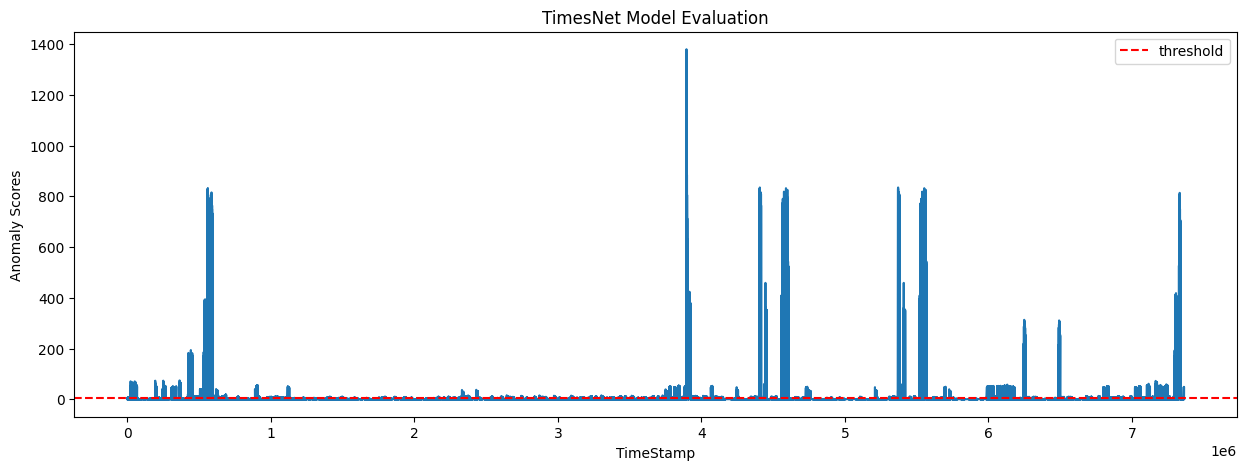

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(test_scores)
plt.axhline(y=final_threshold, color='r', linestyle='--', label='threshold')
plt.title('TimesNet Model Evaluation')
plt.xlabel('TimeStamp')
plt.ylabel('Anomaly Scores')
plt.legend()